# Agriculture Yield input optimization

This is a complex problem as it involves a number of nontrivial aspects, like the interdependencies between several features, relative importanc of features and then we have to determine some sort of causality to say this manual input can affect the yield by so much factor.
To solve this problem we will take a naive approach, understand the business domain, perform feature engineering and then devise a strategy to approach the problem.

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import seaborn as sns
import numpy as np
import re
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn import svm

I have concatenated the contents of all the farms into one sheet "agri"

In [22]:
xl = pd.ExcelFile("agri_data.xlsx")
print(xl.sheet_names)
df = xl.parse("agri")
df = df.fillna(0)

df2 = xl.parse("National Weather Predictions")
#print(df2.head())


['Data from Farmers', 'National Weather Predictions', 'agri']


In [23]:
print(df.head())
vals_set = df.describe()

   Week            category  Fertilizer_added  Fertilizer  Mulch_added  Mulch  \
0     1  Outgrowth Orchards               0.0         0.0          6.0   6.00   
1     2  Outgrowth Orchards               0.0         0.0          0.0   5.85   
2     3  Outgrowth Orchards               0.0         0.0          0.0   5.70   
3     4  Outgrowth Orchards               0.0         0.0          0.0   5.55   
4     5  Outgrowth Orchards               0.0         0.0          0.0   5.40   

   Rain  Watering  Nutrition  Moisture  Sun_Temp  Weekly_Yield  
0  0.86      10.0       75.0      75.0      49.0            43  
1  0.87       0.0       79.0      78.0      50.0            45  
2  0.88      10.0       82.0      77.0      52.0            41  
3  0.87       0.0       86.0      79.0      53.0            51  
4  0.86      10.0       89.0      79.0      54.0            57  


The data from the excel file is the single source of truth here and to limit the scope of the problem we will confine our target limits within the boundary of the data.
So we will split the data into two labels: Good and Bad based on the target (Weekly_Yield).We will take the mean of the data and say any yield less than mean is bad and more than the yield is good. This is required as we don't have ay guidance here as to which yield is considered good.


In [24]:
 
ret = str(vals_set)

input = ret.strip().split("\n")[22]
#print(input)
cut_off = float(re.sub(r'\s+', " ", input).split(" ")[1])
print(cut_off)
df['Good_Yield'] = df['Weekly_Yield'] >= cut_off

65.564103


# 1 Time for some Feature Engineering.

We can remove some of the features from our problem scope. This will help us simplify the problem.
We are going to use Lasso to determine the feature importance for certain assumptions.

Week: This is an important feature.If we consider the domain (Farming) here and our dataset, it is clearly evident that the two crucial environmental features 'Temp' and 'Rain', which can vary with week has been accounted for. So we can rule out week from our features.

Category: Not important, as the names of farms does not give any useful info.Ruled out.

Fertilizer_added: It is a discrete value but fortunately we have Fertilizer content which is some derivate function of this field. So we can remove it from our featureset. Same applied to 'Mulch_added'.

Nutrition/Moisture: Nutrition is an important factor but is actually a function of fertlizer, mulch and water in soil. So if we are considering the three factors, we are in a way accounting for nutrition. Same applies to Moisture.

Now we can handle it two ways. Make two models to predict Nutrition and Moisture, and then make a model to predict yield out of nutrition, mositure and temperature.But the errors introduced in first layer of models will be propagated to next model and will make the solution weak. 
Other approach is that since final output actually depends on the basic factors(fertilizer, mulch, rain, water, temperature), create a model out of these factors and give prediction.

All these assumptions have been derived from below data exploration


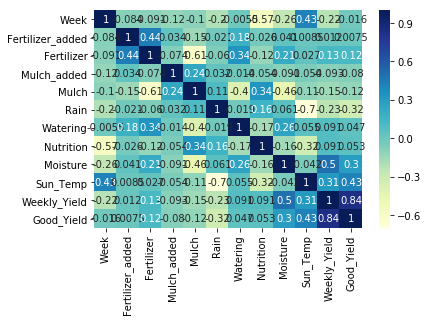

In [25]:
#Determine major fetures from correlation
sns.heatmap(df.corr(), annot=True, cmap="YlGnBu");

In [26]:
#Calculate feature importance for Nutition
from sklearn.linear_model import Lasso

X = np.array(df.drop(['Nutrition', 'category', 'Week', 'Weekly_Yield', 'Fertilizer_added', 'Mulch_added'], 1))
y = np.array(df['Nutrition'])
lasso_reg = None
lasso_reg = Lasso()


# TODO: Fit the model.
lasso_reg.fit(X, y)

# Retrieve and print out the coefficients from the regression model.

reg_coef = lasso_reg.coef_
print("Regularization coeff are{} ".format(reg_coef))

#Calculate feature importance for Moisture
X = np.array(df.drop(['Moisture', 'category', 'Week', 'Weekly_Yield', 'Fertilizer_added', 'Mulch_added'], 1))
y = np.array(df['Moisture'])
lasso_reg = None
lasso_reg = Lasso()



lasso_reg.fit(X, y)

# Retrieve and print out the coefficients from the regression model.

reg_coef = lasso_reg.coef_
print("Regularization coeff are{} ".format(reg_coef))

Regularization coeff are[ 0.          1.59105836 -0.         -0.04530316 -0.08080498 -0.41089758
  3.96984855] 
Regularization coeff are[-0.         -2.81791294  0.          0.14731643 -0.11601857 -0.29426337
  8.60723147] 


# 2 Develop classification model 


'Fertilizer', 'Mulch', 'Rain', 'Watering','Sun_Temp'

These are our major features and we will develop our model around these.
    
First step is to determine what combination of these features is Good or Bad. We have already marked the dataset based on the yield value. Now we will train a Decision Tree to predict the label(Good or Bad) on any given combinations of these features.

In [27]:
data1 = df.drop(['category','Fertilizer_added', 'Mulch_added', 'Week', 'Nutrition', 'Moisture'], axis=1)
data1.head()

,Fertilizer,Mulch,Rain,Watering,Sun_Temp,Weekly_Yield,Good_Yield
0,0.0,6.00,0.86,10.0,49.0,43,False
1,0.0,5.85,0.87,0.0,50.0,45,False
2,0.0,5.70,0.88,10.0,52.0,41,False
3,0.0,5.55,0.87,0.0,53.0,51,False
4,0.0,5.40,0.86,10.0,54.0,57,False


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1107679e8>,
      dtype=object)

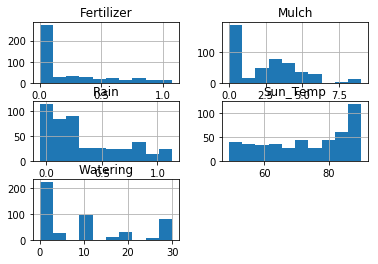

In [28]:
target_raw = data1['Good_Yield']

target = target_raw.apply(lambda x: 0 if x   else 1)

features_raw = data1.drop(['Good_Yield', 'Weekly_Yield'], axis = 1)
features_raw.hist()

In [29]:
random.seed(42)


#scaler = MinMaxScaler() 

numerical = ['Fertilizer','Mulch', 'Rain', 'Watering', 'Sun_Temp']
#features_raw[numerical] = scaler.fit_transform(features_raw[numerical])
features_final = features_raw

# Split the 'features' and 'itarget' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    target, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

features_final.head()

,Fertilizer,Mulch,Rain,Watering,Sun_Temp
0,0.0,6.00,0.86,10.0,49.0
1,0.0,5.85,0.87,0.0,50.0
2,0.0,5.70,0.88,10.0,52.0
3,0.0,5.55,0.87,0.0,53.0
4,0.0,5.40,0.86,10.0,54.0


We are using Adaboost as our model as it can give high performance rather than a single decision tree. We will use GridSearchCV to findout the best hyperparameters for our model.

In [30]:
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), random_state=42)
parameters = {'n_estimators':[20, 50, 120], 
              'learning_rate':[0.1, 0.5, 1.],
              'base_estimator__min_samples_split' : np.arange(2, 8, 2),
              'base_estimator__max_depth' : np.arange(1, 4, 1)
             }

In [31]:

scorer = make_scorer(fbeta_score, beta=0.5)

In [32]:
grid_obj = GridSearchCV(clf, parameters,scoring=scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

/anaconda3/envs/myenv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [33]:

print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Final accuracy score on the testing data: 0.8617
Final F-score on the testing data: 0.8654


# 3 Regression model to calcualte the yield output based on input features.

We will use SVM to create a Regression Model so that it can calculate the yield output based on given inputs.
This will be used in our final solution to find the optimum input values for Fertilizer, Mulch and water.

In [35]:

regr_clf = svm.SVR(gamma='scale', C=1.0, epsilon=0.2)
regr_clf.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='scale',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

# 4 Final Solution

As we are limiting our problem space within the confines of our dataset, we will find the optimum values from our dataset itself.

Idea is to to find all the possible combinations of manual input data and put them into a base dataframe. Noe for every comninaton of provided values(Rain and temp) for each week we will create a dataframe with Rain and Temp values appended to the base daatframe.

Now we will run classifcation on the new dataframe and find out what input values are good or bad. Based on these filtered input values we will calculate which combination will give the maximum amount of yield.

That will be our optimum input value for that particluar week.

In [36]:
mulch_list = list(set(data1['Mulch']))
fert_list = list(set(data1['Fertilizer']))
water_list = list(set(data1['Watering']))
import itertools
val_matrix = list(set(list(itertools.product(fert_list,mulch_list,water_list))))

print(len(val_matrix))
print(val_matrix[99])

labels = ['Fertilizer', 'Mulch', 'Watering']


76860
(0.6153846153846163, 3.846153846153853, 15.0)


In [37]:
#base dataframe
temp_df = pd.DataFrame.from_records(val_matrix, columns=labels)

out_labels = ['Week', 'Fertilizer added (cubic feet)','Fertilizer', 'Mulch added (cubic feet)', 'Mulch', 'Watering', 'Rain', 'Sun_Temp']

#output dataframe to store final solution values
out_df = pd.DataFrame(columns=out_labels )

prev_fert = 0
prev_mulch = 0
prev_water = 0
for week in range(0,52):
    
    #week specific df
    temp_df = pd.DataFrame.from_records(val_matrix, columns=labels)
    temp_df['Rain'] = df2['Rain'][week]
    temp_df['Sun_Temp'] = df2['Temp'][week]
    
    #get class(good or bad)
    predictions = best_clf.predict(temp_df)
    
    #append the predictions to week specific df
    temp_df['predicted'] = predictions
    
    
    #
    tp = np.sum(predictions == 0)
    #print(temp_df.head())
    print("For week {} total number of good points are : {}".format(week, tp))
    
    #Labelled df with filtered rows of input values which are good for this week
    labelled_df = temp_df[temp_df['predicted']==0]
    labelled_df = labelled_df.drop(['predicted'], axis=1)
    
    #Get yield output value for the labelled df
    regr_val = regr_clf.predict(labelled_df)
    labelled_df['regressor'] = regr_val
    
    #Select the input combination with best yield output
    line = str(labelled_df.loc[labelled_df['regressor'].idxmax()])
    fert_added = 0
    mulch_added = 0
    input = line.strip().split("\n")
    
    #Calcuate the discrete values to be used in final solution. 
    fert = float(re.sub(r'\s+', " ", input[0]).split(" ")[1])
    if fert > prev_fert:
        delta_fert = round((fert - prev_fert)/0.5) * 0.5
        fert_added = delta_fert
        
    mulch = float(re.sub(r'\s+', " ", input[1]).split(" ")[1])   
    if mulch > prev_mulch:
        delta_mulch = round(mulch - prev_mulch)
        mulch_added = delta_mulch
        
    wk = int(week +1)
    
    water = float(re.sub(r'\s+', " ", input[2]).split(" ")[1])
    rain = float(re.sub(r'\s+', " ", input[3]).split(" ")[1])
    temp = float(re.sub(r'\s+', " ", input[4]).split(" ")[1])
    
    #The final selcted row of inpt values being pumped into output df
    out_df.loc[week] = [wk, fert_added, fert, mulch_added, mulch, water, rain, temp]
    prev_fert = fert
    prev_mulch = mulch
    
    #temp_df['predictions'] = predictions
print(out_df)



For week 0 total number of good points are : 875
For week 1 total number of good points are : 83
For week 2 total number of good points are : 83
For week 3 total number of good points are : 83
For week 4 total number of good points are : 83
For week 5 total number of good points are : 83
For week 6 total number of good points are : 83
For week 7 total number of good points are : 83
For week 8 total number of good points are : 83
For week 9 total number of good points are : 60794
For week 10 total number of good points are : 31135
For week 11 total number of good points are : 35596
For week 12 total number of good points are : 35596
For week 13 total number of good points are : 25460
For week 14 total number of good points are : 25460
For week 15 total number of good points are : 25460
For week 16 total number of good points are : 25460
For week 17 total number of good points are : 16632
For week 18 total number of good points are : 16632
For week 19 total number of good points are : 16

In [38]:
#dump the solution into csv file
out_df.to_csv('agri_predictions.csv', encoding='utf-8', index=False)